# Demonstration of the TuringOnline package

## Table of contents
1. [Used packages](#import)
1. [Model](#model)    
1. [Data generation](#data)
    1. [Independent variables](#data_indep)
    1. [Dependent variables](#data_dep)
    1. [Suitability](#data_suit)
1. [Benchmark](#bench)
    1. [Speed and memory consumption](#bench_speed)
    1. [Accuracy](#bench_acc)
1. [Repeated updates](#loop)

## Used packages <a name="import"></a>

In [1]:
import PyPlot as plt
import Seaborn as sns
import Pandas as pd

In [2]:
import Random as rnd
import Distributions as dist

In [3]:
import Turing as tur

In [4]:
import AdvancedPS as aps

In [5]:
import DynamicPPL as ppl

In [6]:
rng = rnd.seed!(1)

MersenneTwister(1)

In [7]:
include("../src/TuringOnline.jl")
using Revise
import .online as online

In [8]:
using StatsFuns: logistic

In [9]:
using BenchmarkTools

## Model <a name="model"></a>

In [10]:
tur.@model matrix_galm_possion(cases,totals::Matrix{Int64}) = begin
    # get time steps
    nt=size(cases,1)
    
    # get locations
    ns=size(cases,2)
 
    # Hyperpriors
    sigma ~ dist.Exponential(1)
    sigmaT ~ dist.Exponential(1)
    sigmaS ~ dist.Exponential(1)
    #sigmaM ~ dist.Exponential(1)
   
    # latent space
    theta0 ~ dist.Normal(0.0,sigma)
    bTime ~ tur.filldist(dist.Normal(0.0,sigmaT), nt,1)
    bSpace ~ tur.filldist(dist.Normal(0.0,sigmaS), 1,ns)        
    #M ~ tur.filldist(dist.Normal(0.0,sigmaM), nt,ns)
        
    theta = logistic.(theta0 .+ bTime .+ bSpace)
    
    # likelihood
    for i = 1:nt
        for j = 1:ns            
            cases[i,j] ~ dist.Poisson(totals[i,j]*theta[i,j])            
        end    
    end
   
    # generated quantities
    return (theta=theta,)
end;

## Generate fake data <a name="data"></a>

### Independent variables <a name="data_indep"></a>

In [11]:
numTimeSteps = 20;

In [12]:
time = range(0; stop=10, length=numTimeSteps)

0.0:0.5263157894736842:10.0

In [13]:
numStates = 5;

In [14]:
totals = fill(100,numTimeSteps,numStates)

20×5 Matrix{Int64}:
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100
 100  100  100  100  100

### Prior samples for parameters and dependent variable <a name="data_dep"></a>

In [15]:
missing_cases =  fill(missing,(numTimeSteps,numStates))

20×5 Matrix{Missing}:
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing
 missing  missing  missing  missing  missing

In [16]:
m_missing_full = matrix_galm_possion(missing_cases,totals)

DynamicPPL.Model{typeof(matrix_galm_possion), (:cases, :totals), (), (), Tuple{Matrix{Missing}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(:matrix_galm_possion, matrix_galm_possion, (cases = [missing missing … missing missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing], totals = [100 100 … 100 100; 100 100 … 100 100; … ; 100 100 … 100 100; 100 100 … 100 100]), NamedTuple(), DynamicPPL.DefaultContext())

In [17]:
prior_chain = tur.sample(m_missing_full, tur.Prior(), 2)

Chains MCMC chain (2×130×1 Array{Float64, 3}):

Iterations        = 1:1:2
Number of chains  = 1
Samples per chain = 2
Wall duration     = 4.69 seconds
Compute duration  = 4.69 seconds
parameters        = sigma, sigmaT, sigmaS, theta0, bTime[1,1], bTime[2,1], bTime[3,1], bTime[4,1], bTime[5,1], bTime[6,1], bTime[7,1], bTime[8,1], bTime[9,1], bTime[10,1], bTime[11,1], bTime[12,1], bTime[13,1], bTime[14,1], bTime[15,1], bTime[16,1], bTime[17,1], bTime[18,1], bTime[19,1], bTime[20,1], bSpace[1,1], bSpace[1,2], bSpace[1,3], bSpace[1,4], bSpace[1,5], cases[1,1], cases[1,2], cases[1,3], cases[1,4], cases[1,5], cases[2,1], cases[2,2], cases[2,3], cases[2,4], cases[2,5], cases[3,1], cases[3,2], cases[3,3], cases[3,4], cases[3,5], cases[4,1], cases[4,2], cases[4,3], cases[4,4], cases[4,5], cases[5,1], cases[5,2], cases[5,3], cases[5,4], cases[5,5], cases[6,1], cases[6,2], cases[6,3], cases[6,4], cases[6,5], cases[7,1], cases[7,2], cases[7,3], cases[7,4], cases[7,5], cases[8,1], cases[8,2], cases

In [18]:
generated = tur.generated_quantities(m_missing_full, prior_chain)

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


2×1 Matrix{NamedTuple{(:theta,), Tuple{Matrix{Float64}}}}:
 (theta = [0.3714622608083988 0.5189109789362214 … 0.3059759512725289 0.2644624921818316; 0.5373765743858787 0.6794868406802884 … 0.4642447387435707 0.4140694427615567; … ; 0.5892045635331767 0.7235834424577934 … 0.5169002486599544 0.46598381644280723; 0.5721526815918452 0.7093580478207895 … 0.49939704480011066 0.4486037247665255],)
 (theta = [0.572679106099313 0.46393931118666504 … 0.21543824457846397 0.4447604923254351; 0.5606124769215682 0.45174174278403767 … 0.2072481870316106 0.432660185797836; … ; 0.5553255080826701 0.44643829822949477 … 0.20374839016851404 0.4274061212071883; 0.5554646163696816 0.44657752324744293 … 0.2038398001654323 0.4275439950556054],)

In [19]:
thetaTrue = tur.generated_quantities(m_missing_full, prior_chain)[1][:theta]

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


20×5 Matrix{Float64}:
 0.371462  0.518911  0.370482  0.305976  0.264462
 0.537377  0.679487  0.536332  0.464245  0.414069
 0.788419  0.871809  0.787717  0.735434  0.693911
 0.203434  0.317922  0.202754  0.160028  0.134479
 0.569146  0.706822  0.568116  0.496329  0.44557
 0.554896  0.694682  0.553858  0.481863  0.431316
 0.576871  0.713322  0.575846  0.504223  0.453383
 0.63017   0.756682  0.629191  0.559688  0.508997
 0.558864  0.698082  0.557828  0.485879  0.435265
 0.415837  0.565065  0.414818  0.346845  0.302201
 0.551552  0.691805  0.550513  0.478486  0.428001
 0.484345  0.631577  0.483296  0.412003  0.363641
 0.391613  0.540186  0.390613  0.324407  0.281407
 0.254421  0.383778  0.253625  0.202907  0.171914
 0.509487  0.654659  0.508438  0.436569  0.387223
 0.382694  0.530836  0.381703  0.316224  0.273869
 0.259364  0.389921  0.258559  0.207128  0.175632
 0.606981  0.738129  0.605979  0.535338  0.484427
 0.589205  0.723583  0.588188  0.5169    0.465984
 0.572153  0.709358  0.571124

In [20]:
cases = zeros(Int64,numTimeSteps,numStates)
for i in 1: numTimeSteps
    for j in 1: numStates
        cases[i,j] = prior_chain.value[var=Symbol("cases[$i,$j]")].data[1,1]
    end
end
cases

20×5 Matrix{Int64}:
 36  50  40  34  28
 49  53  51  48  52
 90  89  69  83  58
 20  36  20  14   6
 48  58  49  50  40
 57  57  52  56  34
 54  83  73  43  41
 74  82  61  52  53
 58  71  59  50  53
 49  55  42  29  38
 54  65  40  45  50
 57  68  39  42  27
 31  44  55  30  34
 22  43  17  23  15
 65  64  49  34  33
 33  56  42  29  32
 22  41  25  18  19
 53  74  58  58  40
 58  82  59  54  40
 67  77  60  54  53

### Plot what we have got so far

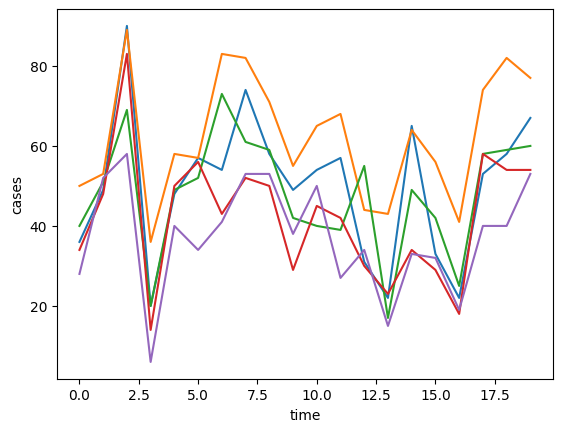

In [21]:
plt.plot(cases);
plt.ylabel("cases");
plt.xlabel("time");

### Show suitablity by inference through NUTS with full data <a name="data_suit"></a>

In [22]:
m_full = matrix_galm_possion(cases,totals)

DynamicPPL.Model{typeof(matrix_galm_possion), (:cases, :totals), (), (), Tuple{Matrix{Int64}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(:matrix_galm_possion, matrix_galm_possion, (cases = [36 50 … 34 28; 49 53 … 48 52; … ; 58 82 … 54 40; 67 77 … 54 53], totals = [100 100 … 100 100; 100 100 … 100 100; … ; 100 100 … 100 100; 100 100 … 100 100]), NamedTuple(), DynamicPPL.DefaultContext())

In [23]:
NUTS = tur.NUTS()

Turing.Inference.NUTS{Turing.Core.ForwardDiffAD{40}, (), AdvancedHMC.DiagEuclideanMetric}(-1, 0.65, 10, 1000.0, 0.0)

In [24]:
num_chains = 2
num_samples = 1000;

In [25]:
chain_NUTS_full =  tur.sample(m_full, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [26]:
thetaEst = map(x -> x[:theta],tur.generated_quantities(m_missing_full,chain_NUTS_full));

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error"

In [27]:
thetaEstMean = dist.mean(thetaEst)

20×5 Matrix{Float64}:
 0.393245  0.535185  0.383535  0.322561  0.280368
 0.537819  0.673799  0.527659  0.461013  0.411726
 0.769822  0.855607  0.762485  0.711131  0.668399
 0.200995  0.308924  0.194449  0.155931  0.131314
 0.513873  0.652367  0.503677  0.437248  0.388674
 0.534639  0.670952  0.524461  0.457846  0.408686
 0.58974   0.718466  0.579835  0.513785  0.463739
 0.650479  0.767485  0.641117  0.577784  0.528347
 0.600505  0.727355  0.590689  0.524964  0.474901
 0.444589  0.587066  0.434524  0.370367  0.324907
 0.530452  0.667196  0.520294  0.4537    0.404639
 0.475143  0.616478  0.464984  0.39954   0.352535
 0.41002   0.552472  0.400182  0.338022  0.294715
 0.249409  0.371255  0.241835  0.196202  0.166431
 0.501584  0.641212  0.491375  0.425168  0.377033
 0.397537  0.53962   0.387794  0.326546  0.284014
 0.262737  0.387728  0.254887  0.207495  0.176393
 0.57982   0.710123  0.569857  0.50358   0.453587
 0.591079  0.719644  0.581181  0.515152  0.465097
 0.634986  0.75529   0.62549

In [28]:
thetaEstStd = dist.std(thetaEst)

20×5 Matrix{Float64}:
 0.0303268  0.0332897  0.0298895  0.027012   0.0257086
 0.0347072  0.0329223  0.0351026  0.0338578  0.0329244
 0.0362718  0.0263709  0.0374303  0.0410645  0.0451261
 0.0227296  0.0303278  0.0214134  0.0181208  0.0161909
 0.034828   0.0333579  0.0354334  0.0338818  0.0327654
 0.0354624  0.0337645  0.0361948  0.034741   0.0347809
 0.0348443  0.0302514  0.034854   0.0363168  0.0356708
 0.0363269  0.0303987  0.0376731  0.0392987  0.0396874
 0.0355691  0.0309134  0.0352949  0.035822   0.0362449
 0.0317682  0.0334641  0.0316697  0.0300394  0.0285522
 0.0365538  0.0346104  0.0363307  0.0355835  0.0346351
 0.0341702  0.0337692  0.0347147  0.0330528  0.0317281
 0.0310327  0.033739   0.0310823  0.0282611  0.0273331
 0.0251785  0.0319658  0.0246508  0.0210718  0.0185952
 0.0335062  0.0320739  0.0339283  0.0328269  0.0317931
 0.0311178  0.0333417  0.0308942  0.0287314  0.0263338
 0.0258373  0.0327103  0.0250826  0.0220355  0.0194138
 0.0351894  0.0307888  0.0349192  0.0348825

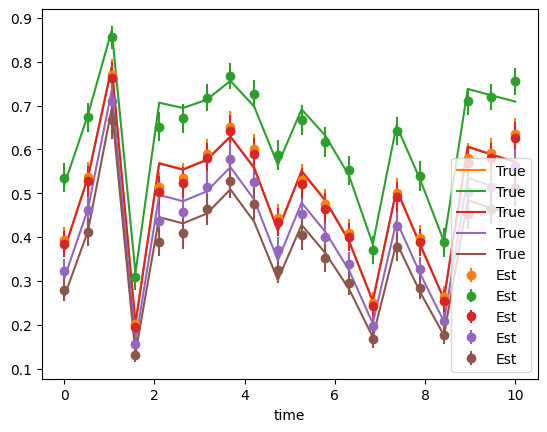

In [29]:
for j in 1:numStates
  plt.plot(time,thetaTrue[:,j],label="True",color="C$j");
  plt.errorbar(x=time,y=thetaEstMean[:,j],yerr=thetaEstStd[:,j],fmt="o",color="C$j",label="Est")
end
plt.legend();
plt.xlabel("time");

## Benchmark of updating <a name="bench"></a>

In [30]:
someTime = length(time)-1

19

In [31]:
cases_t =  cases[1:someTime,:]

19×5 Matrix{Int64}:
 36  50  40  34  28
 49  53  51  48  52
 90  89  69  83  58
 20  36  20  14   6
 48  58  49  50  40
 57  57  52  56  34
 54  83  73  43  41
 74  82  61  52  53
 58  71  59  50  53
 49  55  42  29  38
 54  65  40  45  50
 57  68  39  42  27
 31  44  55  30  34
 22  43  17  23  15
 65  64  49  34  33
 33  56  42  29  32
 22  41  25  18  19
 53  74  58  58  40
 58  82  59  54  40

In [32]:
cases_t_inc = cases[1:someTime+1,:]

20×5 Matrix{Int64}:
 36  50  40  34  28
 49  53  51  48  52
 90  89  69  83  58
 20  36  20  14   6
 48  58  49  50  40
 57  57  52  56  34
 54  83  73  43  41
 74  82  61  52  53
 58  71  59  50  53
 49  55  42  29  38
 54  65  40  45  50
 57  68  39  42  27
 31  44  55  30  34
 22  43  17  23  15
 65  64  49  34  33
 33  56  42  29  32
 22  41  25  18  19
 53  74  58  58  40
 58  82  59  54  40
 67  77  60  54  53

In [33]:
model_t = matrix_galm_possion(cases_t,totals)

DynamicPPL.Model{typeof(matrix_galm_possion), (:cases, :totals), (), (), Tuple{Matrix{Int64}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(:matrix_galm_possion, matrix_galm_possion, (cases = [36 50 … 34 28; 49 53 … 48 52; … ; 53 74 … 58 40; 58 82 … 54 40], totals = [100 100 … 100 100; 100 100 … 100 100; … ; 100 100 … 100 100; 100 100 … 100 100]), NamedTuple(), DynamicPPL.DefaultContext())

In [34]:
model_t_inc = matrix_galm_possion(cases_t_inc,totals)

DynamicPPL.Model{typeof(matrix_galm_possion), (:cases, :totals), (), (), Tuple{Matrix{Int64}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(:matrix_galm_possion, matrix_galm_possion, (cases = [36 50 … 34 28; 49 53 … 48 52; … ; 58 82 … 54 40; 67 77 … 54 53], totals = [100 100 … 100 100; 100 100 … 100 100; … ; 100 100 … 100 100; 100 100 … 100 100]), NamedTuple(), DynamicPPL.DefaultContext())

#### Get a chain from nuts

In [35]:
chain_t = tur.sample(model_t, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Chains MCMC chain (1000×40×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 5.36 seconds
Compute duration  = 10.56 seconds
parameters        = sigma, sigmaT, sigmaS, theta0, bTime[1,1], bTime[2,1], bTime[3,1], bTime[4,1], bTime[5,1], bTime[6,1], bTime[7,1], bTime[8,1], bTime[9,1], bTime[10,1], bTime[11,1], bTime[12,1], bTime[13,1], bTime[14,1], bTime[15,1], bTime[16,1], bTime[17,1], bTime[18,1], bTime[19,1], bSpace[1,1], bSpace[1,2], bSpace[1,3], bSpace[1,4], bSpace[1,5]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
   parameters      mean       std   naive_se      mcse         ess      rhat   ⋯
       Symbol   Float64   Float64    Float64   Float64     Float64   Float64   ⋯

        sigma    0.5332    0.6042     0.0135    0.0196    957.148

### Speed and memory consumption <a name="bench_speed"></a>

In [36]:
@benchmark online.update(chain_t,model_t_inc,tur.SMC(),rng) seconds = 20

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  3.471 s …    4.228 s  ┊ GC (min … max): 11.78% … 18.62%
 Time  (median):     3.921 s               ┊ GC (median):    16.62%
 Time  (mean ± σ):   3.850 s ± 313.147 ms  ┊ GC (mean ± σ):  16.68% ±  5.18%

  █                               ▁   ▁         ▁          ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█ ▁
  3.47 s         Histogram: frequency by time         4.23 s <

 Memory estimate: 3.08 GiB, allocs estimate: 11054539.

In [37]:
@benchmark tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true) seconds = 20

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  4.573 s …    5.712 s  ┊ GC (min … max): 14.27% … 13.98%
 Time  (median):     4.936 s               ┊ GC (median):    13.98%
 Time  (mean ± σ):   5.066 s ± 518.013 ms  ┊ GC (mean ± σ):  14.57% ±  0.83%

  ██                █                            █         █  
  ██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█ ▁
  4.57 s         Histogram: frequency by time         5.71 s <

 Memory estimate: 5.19 GiB, allocs estimate: 10083967.

In [38]:
using Profile

In [39]:
@profile online.update(chain_t,model_t_inc,tur.SMC(),rng)

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (1000×31×2 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 2
Samples per chain = 1000
parameters        = sigma, sigmaT, sigmaS, theta0, bTime[1,1], bTime[2,1], bTime[3,1], bTime[4,1], bTime[5,1], bTime[6,1], bTime[7,1], bTime[8,1], bTime[9,1], bTime[10,1], bTime[11,1], bTime[12,1], bTime[13,1], bTime[14,1], bTime[15,1], bTime[16,1], bTime[17,1], bTime[18,1], bTime[19,1], bTime[20,1], bSpace[1,1], bSpace[1,2], bSpace[1,3], bSpace[1,4], bSpace[1,5]
internals         = lp, weight

Summary Statistics
   parameters      mean       std   naive_se      mcse        ess      rhat 
       Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

        sigma    0.6258    0.4596     0.0103    0.0555    11.9295    1.2533
       sigmaT    0.7887    0.1364     0.0030    0.0186     8.6036    1.2869
       sigmaS    0.4953    0.1848     0.0041    0.0227    17.1531    1.1584
       theta0   -0.0018    0.2535     0.0057    0.0348     6.0729    1.701

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/konstantin/.julia/packages/MCMCChains/pPqxj/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/konstantin/.julia/packages/MCMCChains/pPqxj/src/chains.jl:364


In [40]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
   1╎1    @Base/asyncevent.jl:97; _trywait(t::Timer)
   1╎1    ...ler/ssair/passes.jl:913; adce_pass!(ir::Core.Compiler.IR...
   1╎1    @Base/intfuncs.jl:761; string(n::Int64; base::Int64, p...
   1╎1    @Base/pcre.jl:34; get_local_match_context()
   1╎1    ...e/strings/string.jl:153; _nextind_str(s::String, i::Int64)
    ╎647  @Base/task.jl:411; (::IJulia.var"#15#18")()
    ╎ 647  ...lia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
    ╎  647  @Base/essentials.jl:706; invokelatest
    ╎   647  @Base/essentials.jl:708; #invokelatest#2
    ╎    647  ...execute_request.jl:67; execute_request(socket::ZMQ.S...
    ╎     647  ...SoftGlobalScope.jl:65; softscope_include_string(m::...
    ╎    ╎ 647  @Base/loading.jl:1116; include_string(mapexpr::typ...
   3╎    ╎  647  @Base/boot.jl:360; eval
    ╎    ╎   631  .../TuringOnline.jl:288; update(chain::MCMCChains.C...
    ╎    ╎    631  .../TuringOnline.jl:145; convertChainToParticle

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +19 1    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +20 1    ...tation.jl:143; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +21 1    ...tation.jl:490; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +22 1    ...einfer.jl:796; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +23 1    .../types.jl:33; InferenceResult
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +24 1    .../types.jl:33; InferenceResult
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +25 1    ...result.jl:50; matching_cache_...
   9╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  12   ...sMeter.jl:304; updateProgress!...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎   3    ...einfer.jl:921; typeinf_ext_top...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎    3    ...einfer.jl:925; typeinf_ext_top...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎     3    ...einfer.jl:892; typeinf_ext(int...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +1 3    ...einf

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +8 10   ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +9 10   ...tation.jl:143; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +10 10   ...tation.jl:490; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +11 10   ...einfer.jl:806; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +12 10   ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 9    ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 9    ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 7    ...tation.jl:1447; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 7    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 7    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +18 7    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 1    ...einfer.jl:769; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 1    ...lities.jl:178; specialize_method
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 1    ...lities.jl:191; specialize_meth...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 2    ...einfer.jl:806; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 2    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 2    ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 2    ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 2    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +18 2    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +19 2    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +20 2    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +18 3    ...driver.jl:129; run_passes(ci::...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +19 2    ...lining.jl:68; ssa_inlining_pa...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +20 1    ...lining.jl:1155; assemble_inline...
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +21 1    ...lining.jl:1049; process_simple!...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +20 1    ...lining.jl:1203; assemble_inline...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +21 1    ...lining.jl:1102; analyze_single_...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +22 1    ...lining.jl:758; analyze_method!...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +23 1    ...lining.jl:704; resolve_todo(to...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +24 1    ...lining.jl:771; Core.Compiler.I...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +25 1    ...legacy.jl:10; inflate_ir(ci::...
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +26 1    ...ntials.jl:0; inflate_ir(ci::...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +1

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +5 5    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +6 5    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +7 5    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +8 5    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  +9 5    ...tation.jl:143; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +10 5    ...tation.jl:490; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +11 5    ...einfer.jl:806; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +12 5    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 4    ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 4    ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 4    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +34 2    ...einfer.jl:806; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +35 2    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +36 2    ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +37 2    ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +38 2    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +39 2    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +40 2    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +41 2    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +42 2    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +43 2    ...tation.jl:143; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +44 2    ...tation.jl:490; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  

   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +72 1    ...ection.jl:867; _methods_by_ftype
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +60 3    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +61 3    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +62 3    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +63 3    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +64 3    ...tation.jl:952; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +65 3    ...tation.jl:738; abstract_apply(...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +66 3    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +67 3    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +68 3    ...tation.jl:143; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +69 3    ...tation.jl:490; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎   

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +68 1    ...tation.jl:143; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +69 1    ...tation.jl:490; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +70 1    ...einfer.jl:806; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +71 1    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +72 1    ...einfer.jl:269; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +73 1    ...einfer.jl:478; store_backedges
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +74 1    ...einfer.jl:488; store_backedges...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +52 1    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +53 1    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +54 1    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +55 1    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +71 1    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +72 1    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +73 1    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +74 1    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +75 1    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +76 1    ...tation.jl:143; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +77 1    ...tation.jl:490; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +78 1    ...einfer.jl:806; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +79 1    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +80 1    ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +81 1    ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +57 4    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +58 4    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +59 4    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +60 4    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +61 4    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +62 4    ...tation.jl:168; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +63 1    ...tation.jl:325; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +64 1    .../types.jl:33; InferenceResult
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +65 1    ...result.jl:18; matching_cache_...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +63 3    ...tation.jl:330; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +64 3    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +6

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +30 5    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +31 2    ...tation.jl:84; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +32 2    ...dtable.jl:65; (::Core.Compile...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +33 2    ...dtable.jl:66; #findall#217
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +34 2    ...iddict.jl:163; get!
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +35 2    ...dtable.jl:67; (::Core.Compile...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +36 2    ...dtable.jl:54; (::Core.Compile...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +37 2    ...dtable.jl:57; #findall#216
   2╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +38 2    ...ection.jl:867; _methods_by_ftype
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +31 3    ...tation.jl:168; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +32 3    ...tation.jl:330; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +33 3    ...einfer.jl:209; typeinf

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +28 1    ...air/ir.jl:1248; iterate(compact...
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +29 1    ...air/ir.jl:948; process_node!(c...
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +21 1    ...tation.jl:207; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 1    ...tation.jl:1465; typeinf_local(i...
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 1    ...estate.jl:222; record_ssa_assi...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 3    ...einfer.jl:244; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 3    ...timize.jl:272; optimize
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 1    ...driver.jl:125; run_passes(ci::...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 1    ...driver.jl:118; slot2reg
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +18 1    ...ot2ssa.jl:869; construct_ssa!(...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 1    ...driver.jl:129; run_passes(ci::...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 1    ...lining.j

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +32 2    ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +33 2    ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +34 1    ...tation.jl:1447; typeinf_local(i...
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +35 1    ...tation.jl:0; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +34 1    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +35 1    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +36 1    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +37 1    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +38 1    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +39 1    ...tation.jl:168; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +40 1    ...tation.jl:330; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎   

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +25 11   ...einfer.jl:806; typeinf_edge(in...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +26 11   ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +27 11   ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +28 11   ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +29 11   ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +30 11   ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +31 11   ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +32 11   ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +33 11   ...tation.jl:952; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +34 11   ...tation.jl:738; abstract_apply(...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +35 11   ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +89 1    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +90 1    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +91 1    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +92 1    ...tation.jl:168; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +93 1    ...tation.jl:330; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +94 1    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +95 1    ...einfer.jl:244; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +96 1    ...timize.jl:272; optimize
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +97 1    ...driver.jl:125; run_passes(ci::...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +98 1    ...driver.jl:118; slot2reg
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +99 1    ...ot2ssa.jl:893; construct_ssa!(...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +65 1    ...einfer.

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +53 1    ...tation.jl:168; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +54 1    ...tation.jl:330; abstract_call_m...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +55 1    ...einfer.jl:209; typeinf(interp:...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +56 1    ...einfer.jl:214; _typeinf(interp...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +57 1    ...tation.jl:1520; typeinf_nocycle...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +58 1    ...tation.jl:1462; typeinf_local(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +59 1    ...tation.jl:1167; abstract_eval_s...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +60 1    ...tation.jl:1040; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +61 1    ...tation.jl:1056; abstract_call(i...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +62 1    ...tation.jl:1033; abstract_call_k...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +63 1    ...tation.jl:168; abstract_call_g...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  

    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 2    ...ngs/io.jl:101; sprint(::Functi...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 2    ...buffer.jl:112; Type##kw
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 2    ...buffer.jl:114; IOBuffer(; read...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 2    ...buffer.jl:31; StringVector
   2╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 2    ...string.jl:85; unsafe_wrap
   3╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 12   ...ngs/io.jl:105; sprint(::Functi...
   2╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 2    ...tfuncs.jl:679; dec(x::UInt64, ...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 7    ...ngs/io.jl:288; join(io::IOBuff...
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 1    ...ngs/io.jl:34; print(io::IOBuf...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 6    ...ngs/io.jl:35; print(io::IOBuf...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 6    ...e/show.jl:969; show
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 3    ...tfuncs.jl:762; string
    ╎    

    ╎    ╎    ╎    ╎    ╎    ╎    ╎ 2    ...e/dict.jl:101; Dict{String, Bi...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  2    ...e/dict.jl:90; Dict{String, Bi...
   2╎    ╎    ╎    ╎    ╎    ╎    ╎   2    ...e/boot.jl:448; Array
    ╎    ╎    ╎    ╎    ╎    ╎    ╎ 3    ...e/dict.jl:103; Dict{String, Bi...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  3    ...erator.jl:47; iterate
    ╎    ╎    ╎    ╎    ╎    ╎    ╎   3    none:0; (::DynamicPPL.v...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    3    ...tarray.jl:1170; getindex
    ╎    ╎    ╎    ╎    ╎    ╎    ╎     1    ...sional.jl:831; _getindex
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ 1    ...tarray.jl:616; checkbounds
   1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  1    ...tarray.jl:0; checkbounds
    ╎    ╎    ╎    ╎    ╎    ╎    ╎     2    ...sional.jl:832; _getindex
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ 2    ...sional.jl:844; _unsafe_getinde...
    ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎  2    ...tarray.jl:740; similar
    ╎    ╎    ╎    ╎    ╎    ╎    ╎  

    ╎   1248 ...S/src/container.jl:326; sweep!
    ╎    7    ...S/src/container.jl:336; sweep!(rng::Random.MersenneT...
    ╎     7    .../src/container.jl:273; reweight!(pc::AdvancedPS.Par...
    ╎    ╎ 7    ...core/container.jl:26; advance!(trace::AdvancedPS.T...
    ╎    ╎  1    ...task/src/ctask.jl:188; consume(::Libtask.CTask)
   1╎    ╎   1    @Base/iddict.jl:141; get!(d::IdDict{Any, Any}, ...
    ╎    ╎  2    ...task/src/ctask.jl:207; consume(::Libtask.CTask)
    ╎    ╎   2    @Base/task.jl:662; yield()
    ╎    ╎    2    @Base/task.jl:770; wait
   2╎    ╎     2    @Base/libuv.jl:104; process_events
    ╎    ╎  4    ...task/src/ctask.jl:221; consume(::Libtask.CTask)
    ╎    ╎   1    @Base/task.jl:769; wait
   1╎    ╎    1    @Base/task.jl:700; try_yieldto(undo::typeof(...
    ╎    ╎   3    @Base/task.jl:770; wait
   3╎    ╎    3    @Base/libuv.jl:104; process_events
    ╎    797  ...S/src/container.jl:347; sweep!(rng::Random.MersenneT...
    ╎     797  .../src/container.jl:246;

    ╎    ╎    ╎    ╎ 8    ...e/deepcopy.jl:61; deepcopy_internal(x::...
   8╎    ╎    ╎    ╎  8    @Base/iddict.jl:81; setindex!(d::IdDict{A...
   1╎    ╎    ╎    ╎ 1    ...e/deepcopy.jl:63; deepcopy_internal(x::...
   5╎    ╎    ╎    ╎ 5    ...e/deepcopy.jl:64; deepcopy_internal(x::...
  60╎    ╎    ╎    ╎ 73   ...e/deepcopy.jl:65; deepcopy_internal(x::...
   1╎    ╎    ╎    ╎  1    ...e/deepcopy.jl:53; deepcopy_internal(x::...
    ╎    ╎    ╎    ╎  1    ...e/deepcopy.jl:89; deepcopy_internal(x::...
    ╎    ╎    ╎    ╎   1    ...stractdict.jl:17; haskey
    ╎    ╎    ╎    ╎    1    @Base/iddict.jl:174; in
   1╎    ╎    ╎    ╎     1    @Base/iddict.jl:87; get
    ╎    ╎    ╎    ╎  11   ...e/deepcopy.jl:92; deepcopy_internal(x::...
    ╎    ╎    ╎    ╎   11   ...e/deepcopy.jl:97; _deepcopy_array_t
   5╎    ╎    ╎    ╎    5    @Base/array.jl:349; copy
   6╎    ╎    ╎    ╎    6    @Base/iddict.jl:81; setindex!(d::IdDict...
   5╎    ╎    ╎    ╎ 5    ...e/deepcopy.jl:66; deepcopy_internal(

    ╎   1    ...src/TuringOnline.jl:70; changeParticleCoordinates(vari...
   1╎    1    @Base/namedtuple.jl:118; getindex
   5╎   5    ...src/TuringOnline.jl:73; changeParticleCoordinates(vari...
    ╎   1    ...src/TuringOnline.jl:76; changeParticleCoordinates(vari...
   1╎    1    @Base/array.jl:801; getindex
   5╎   476  ...src/TuringOnline.jl:81; changeParticleCoordinates(vari...
    ╎    1    @Base/array.jl:683; collect(itr::Base.Generator{...
    ╎     1    @Base/array.jl:669; _array_for
   1╎    ╎ 1    @Base/boot.jl:448; Array
    ╎    8    @Base/reflection.jl:176; fieldnames
   5╎     6    @Base/reflection.jl:710; fieldcount(t::Any)
   1╎    ╎ 1    @Base/operators.jl:174; ==(T::Type, S::Type)
    ╎     2    @Base/reflection.jl:717; fieldcount(t::Any)
    ╎    ╎ 1    @Base/tuple.jl:89; indexed_iterate
    ╎    ╎  1    @Base/essentials.jl:599; iterate
    ╎    ╎   1    @Base/essentials.jl:599; iterate
   1╎    ╎    1    @Base/int.jl:83; <
    ╎    ╎ 1    @Base/tuple.jl:94; indexe

    ╎    ╎    ╎  80   @Base/array.jl:724; collect_to!(dest::Vector...
    ╎    ╎    ╎   80   @Base/generator.jl:47; iterate
    ╎    ╎    ╎    80   .../src/chains.jl:230; #39
    ╎    ╎    ╎     80   ...c/indexing.jl:123; getindex
    ╎    ╎    ╎    ╎ 80   ...c/indexing.jl:130; getindex_converted
    ╎    ╎    ╎    ╎  80   ...c/indexing.jl:104; getindex
    ╎    ╎    ╎    ╎   80   ...ractarray.jl:1170; getindex
    ╎    ╎    ╎    ╎    80   ...mensional.jl:832; _getindex
    ╎    ╎    ╎    ╎     38   ...ensional.jl:844; _unsafe_getindex(::...
    ╎    ╎    ╎    ╎    ╎ 38   ...actarray.jl:740; similar
    ╎    ╎    ╎    ╎    ╎  38   @Base/array.jl:358; similar
    ╎    ╎    ╎    ╎    ╎   38   @Base/boot.jl:458; Array
  36╎    ╎    ╎    ╎    ╎    38   @Base/boot.jl:450; Array
    ╎    ╎    ╎    ╎    ╎     2    ...e/regex.jl:46; (::Base.var"#391...
   2╎    ╎    ╎    ╎    ╎    ╎ 2    ...e/pcre.jl:144; free_re
    ╎    ╎    ╎    ╎     42   ...ensional.jl:846; _unsafe_getindex(::...
    ╎   

    ╎    ╎    ╎ 2    @Base/array.jl:602; collect
    ╎    ╎    ╎  2    @Base/array.jl:608; _collect
    ╎    ╎    ╎   1    ...stractarray.jl:847; copyto!(dest::Vector{An...
    ╎    ╎    ╎    1    @Base/dict.jl:695; iterate
    ╎    ╎    ╎     1    @Base/dict.jl:670; skip_deleted
    ╎    ╎    ╎    ╎ 1    @Base/dict.jl:172; isslotfilled
   1╎    ╎    ╎    ╎  1    .../promotion.jl:410; ==
    ╎    ╎    ╎   1    @Base/array.jl:575; _similar_for
    ╎    ╎    ╎    1    ...stractarray.jl:742; similar
    ╎    ╎    ╎     1    ...tractarray.jl:750; similar
    ╎    ╎    ╎    ╎ 1    @Base/boot.jl:457; Array
   1╎    ╎    ╎    ╎  1    @Base/boot.jl:448; Array
    ╎    ╎   8    ...ains/src/utils.jl:61; _dict2namedtuple(d::Dict{An...
   1╎    ╎    8    @Base/ntuple.jl:19; ntuple
    ╎    ╎     6    @Base/ntuple.jl:37; _ntuple(f::MCMCChains.var...
   2╎    ╎    ╎ 6    @Base/array.jl:683; collect(itr::Base.Genera...
    ╎    ╎    ╎  4    @Base/array.jl:702; collect_to_with_first!(d...
    ╎    ╎  

   3╎    ╎    ╎    ╎    ╎ 3    @Base/pcre.jl:166; exec(re::Ptr{Nothi...
   1╎    ╎    ╎    ╎    1    @Base/regex.jl:300; match(re::Regex, st...
    ╎    ╎    ╎    ╎    1    @Base/regex.jl:307; match(re::Regex, st...
    ╎    ╎    ╎    ╎     1    @Base/array.jl:670; _array_for
    ╎    ╎    ╎    ╎    ╎ 1    ...actarray.jl:784; similar
    ╎    ╎    ╎    ╎    ╎  1    ...actarray.jl:785; similar
    ╎    ╎    ╎    ╎    ╎   1    @Base/boot.jl:457; Array
   1╎    ╎    ╎    ╎    ╎    1    @Base/boot.jl:448; Array
    ╎    ╎    ╎    ╎  2    ...strings/io.jl:176; string
    ╎    ╎    ╎    ╎   2    ...ngs/string.jl:83; String
   2╎    ╎    ╎    ╎    2    ...gs/string.jl:71; unsafe_string
    ╎    ╎    ╎    1    ...e/iterators.jl:454; iterate(f::Base.Iterat...
    ╎    ╎    ╎     1    .../iterators.jl:257; iterate
   1╎    ╎    ╎    ╎ 1    @Base/array.jl:801; getindex
    ╎    ╎    ╎  1    @Base/array.jl:765; grow_to!(dest::Vector{In...
    ╎    ╎    ╎   1    @Base/array.jl:929; push!
   1╎    ╎

    ╎    ╎    ╎   3    @Base/array.jl:724; collect_to!(dest::Vecto...
    ╎    ╎    ╎    3    ...e/generator.jl:47; iterate
   1╎    ╎    ╎     3    ...s/src/utils.jl:60; (::MCMCChains.var"#11#...
    ╎    ╎    ╎    ╎ 2    @Base/array.jl:602; collect
    ╎    ╎    ╎    ╎  2    @Base/array.jl:608; _collect
    ╎    ╎    ╎    ╎   1    ...ractarray.jl:847; copyto!(dest::Vector...
    ╎    ╎    ╎    ╎    1    @Base/dict.jl:695; iterate
   1╎    ╎    ╎    ╎     1    @Base/dict.jl:670; skip_deleted
    ╎    ╎    ╎    ╎   1    @Base/array.jl:575; _similar_for
    ╎    ╎    ╎    ╎    1    ...ractarray.jl:742; similar
    ╎    ╎    ╎    ╎     1    ...actarray.jl:750; similar
    ╎    ╎    ╎    ╎    ╎ 1    @Base/boot.jl:457; Array
   1╎    ╎    ╎    ╎    ╎  1    @Base/boot.jl:448; Array
   2╎    ╎     3    ...ins/src/utils.jl:60; (::MCMCChains.var"#11#13"...
    ╎    ╎    ╎ 1    @Base/array.jl:602; collect
    ╎    ╎    ╎  1    @Base/array.jl:608; _collect
    ╎    ╎    ╎   1    @Base/array.jl:5

    ╎    ╎    ╎    ╎    ╎ 1    @Base/array.jl:1855; findnext
   1╎    ╎    ╎    ╎    ╎  1    @Base/array.jl:801; getindex
    ╎    ╎ 1    @Base/array.jl:728; collect_to!
   1╎    ╎  1    @Base/array.jl:839; setindex!
  18╎    20   @Base/generator.jl:0; collect(itr::Base.Generator{...
    ╎     2    @Base/regex.jl:46; (::Base.var"#391#392")(re::R...
   2╎    ╎ 2    @Base/pcre.jl:144; free_re
    ╎   45   ...src/TuringOnline.jl:99; changeParticleCoordinates(vari...
   2╎    45   ...field/src/sugar.jl:192; macro expansion
   1╎     1    ...field/src/lens.jl:186; set(obj::DynamicPPL.TypedVar...
    ╎     32   ...field/src/lens.jl:188; set(obj::DynamicPPL.TypedVar...
    ╎    ╎ 1    ...field/src/lens.jl:187; set(obj::NamedTuple{(:sigma...
    ╎    ╎  1    ...field/src/lens.jl:202; get
   1╎    ╎   1    @Base/namedtuple.jl:118; getindex
    ╎    ╎ 5    ...field/src/lens.jl:188; set(obj::NamedTuple{(:sigma...
   4╎    ╎  5    ...field/src/lens.jl:122; set
    ╎    ╎   1    ...nstructionBase.j

    ╎    ╎    ╎     2    ...dvancedSMC.jl:325; assume(rng::Random._GL...
   2╎    ╎    ╎    ╎ 2    @Base/Base.jl:33; getproperty(x::Turing....
    ╎    ╎    ╎     1    ...dvancedSMC.jl:327; assume(rng::Random._GL...
    ╎    ╎    ╎    ╎ 1    ...rc/varinfo.jl:1039; haskey(vi::DynamicPPL...
    ╎    ╎    ╎    ╎  1    ...reflection.jl:176; fieldnames
   1╎    ╎    ╎    ╎   1    ...eflection.jl:710; fieldcount(t::Any)
    ╎    ╎    ╎     1    ...dvancedSMC.jl:330; assume(rng::Random._GL...
    ╎    ╎    ╎    ╎ 1    ...rc/varinfo.jl:1175; is_flagged(vi::Dynami...
   1╎    ╎    ╎    ╎  1    ...e/bitarray.jl:678; getindex
    ╎    ╎    ╎     1    ...dvancedSMC.jl:337; assume(rng::Random._GL...
    ╎    ╎    ╎    ╎ 1    ...rc/varinfo.jl:1250; updategid!(vi::Dynami...
    ╎    ╎    ╎    ╎  1    ...rc/varinfo.jl:638; setgid!
   1╎    ╎    ╎    ╎   1    @Base/array.jl:801; getindex
    ╎    ╎     2    In[10]:10; matrix_galm_possion(__mod...
    ╎    ╎    ╎ 2    ...lementations.jl:140; tilde_assum

   1╎    ╎    ╎    ╎   1    @Base/iddict.jl:91; getindex(d::IdDict{An...
    ╎    ╎    ╎    ╎  1    .../src/ctask.jl:157; produce(v::Float64)
   1╎    ╎    ╎    ╎   1    @Base/task.jl:170; getproperty
    ╎    ╎    ╎  18   ...lementations.jl:206; tilde_observe!
   1╎    ╎    ╎   1    @Base/array.jl:0; acclogp!
    ╎    ╎    ╎   17   ...c/threadsafe.jl:19; acclogp!
   4╎    ╎    ╎    4    @Base/array.jl:801; getindex
    ╎    ╎    ╎    4    @Base/refvalue.jl:57; setindex!
   4╎    ╎    ╎     4    @Base/Base.jl:34; setproperty!
   9╎    ╎    ╎    9    ...gconstructs.jl:10; threadid
   1╎    ╎    ╎ 1    .../distrs/pois.jl:19; poislogpdf(λ::Float64, x...
    ╎ 2    ...PS/src/container.jl:12; #1
   1╎  1    @Libtask/src/ctask.jl:122; produce(v::Nothing)
    ╎  1    @Libtask/src/ctask.jl:146; produce(v::Nothing)
    ╎   1    @Base/task.jl:660; yield()
    ╎    1    @Base/task.jl:590; enq_work(t::Task)
   1╎     1    @Base/task.jl:523; push!(W::Base.InvasiveLinked...
Total snapshots: 9251


### Accuracy <a name="bench_acc"></a>

In [41]:
newChain = online.update(chain_t,model_t_inc,tur.SMC(),rng);

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.


In [42]:
chain_t_inc = tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Info: Found initial step size
│   ϵ = 0.01171875
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [43]:
dictChains = Dict("update" => newChain, "nuts" => chain_t_inc , "true" => prior_chain);

In [44]:
dictColor = Dict("update" => "C1", "nuts" => "C2" , "true" => "k");

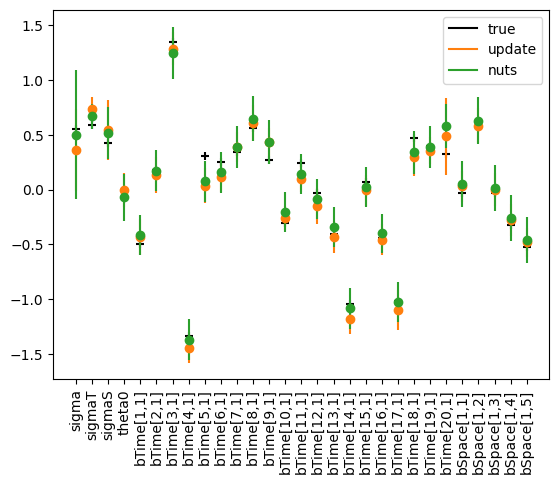

In [45]:
for (i,sym) in enumerate(chain_t_inc.name_map.parameters)
    for (k,v) in dictChains
        if sym in v.name_map.parameters
            if k != "true"
                # compute statistics
                samples = collect(Iterators.flatten(v[sym].data))
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # plot errorbars
                plt.errorbar(x=i,y=mean,yerr=std,fmt="o",color=dictColor[k])
            else 
                # plot true
                plt.scatter([i],v[sym].data[1,:],color="k",marker="+")
            end
        end        
    
    end
end
# add labels
for (ckey,cvalue) in dictColor
    plt.plot([],[],label=ckey,color=cvalue)
end
plt.legend()

# ticks
plt.xticks(1:length(chain_t_inc.name_map.parameters), chain_t_inc.name_map.parameters, rotation="vertical")

plt.show()

## Repeated updates <a name="loop"></a>

In [46]:
chainDict = Dict()

Dict{Any, Any}()

In [47]:
smc = tur.SMC()

Turing.Inference.SMC{(), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5))

In [48]:
for (i,t) in enumerate(time)
   
    # set up model
    model_t = matrix_galm_possion(cases[1:i,:],totals)
    
    if i == 1
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    elseif i ==2
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"NUTS")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    else
        println("NUTS at $i.")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"Online")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    end
end

NUTS at 1


┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 1
NUTS at 2


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 2
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[2,1]")]) 
Using prior samples from the model for them instead.
SMC at 2
NUTS at 3.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 3
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[3,1]")]) 
Using prior samples from the model for them instead.
SMC at 3
NUTS at 4.


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 4
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[4,1]")]) 
Using prior samples from the model for them instead.
SMC at 4
NUTS at 5.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 5
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[5,1]")]) 
Using prior samples from the model for them instead.
SMC at 5
NUTS at 6.


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 6
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[6,1]")]) 
Using prior samples from the model for them instead.
SMC at 6
NUTS at 7.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 7
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[7,1]")]) 
Using prior samples from the model for them instead.
SMC at 7
NUTS at 8.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 8
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[8,1]")]) 
Using prior samples from the model for them instead.
SMC at 8
NUTS at 9.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 9
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[9,1]")]) 
Using prior samples from the model for them instead.
SMC at 9
NUTS at 10.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 10
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[10,1]")]) 
Using prior samples from the model for them instead.
SMC at 10
NUTS at 11.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 11
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[11,1]")]) 
Using prior samples from the model for them instead.
SMC at 11
NUTS at 12.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 12
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[12,1]")]) 
Using prior samples from the model for them instead.
SMC at 12
NUTS at 13.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 13
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[13,1]")]) 
Using prior samples from the model for them instead.
SMC at 13
NUTS at 14.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 14
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[14,1]")]) 
Using prior samples from the model for them instead.
SMC at 14
NUTS at 15.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 15
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[15,1]")]) 
Using prior samples from the model for them instead.
SMC at 15
NUTS at 16.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 16
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[16,1]")]) 
Using prior samples from the model for them instead.
SMC at 16
NUTS at 17.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 17
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[17,1]")]) 
Using prior samples from the model for them instead.
SMC at 17
NUTS at 18.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 18
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[18,1]")]) 
Using prior samples from the model for them instead.
SMC at 18
NUTS at 19.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 19
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[19,1]")]) 
Using prior samples from the model for them instead.
SMC at 19
NUTS at 20.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 20
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
SMC at 20


## Analysis

In [49]:
chainDict

Dict{Any, Any} with 59 entries:
  (15, "SMC")    => MCMC chain (100×26×2 Array{Float64, 3})
  (11, "NUTS")   => MCMC chain (100×32×2 Array{Float64, 3})
  (14, "Online") => MCMC chain (100×25×2 Array{Float64, 3})
  (3, "Online")  => MCMC chain (100×14×2 Array{Float64, 3})
  (5, "SMC")     => MCMC chain (100×16×2 Array{Float64, 3})
  (7, "NUTS")    => MCMC chain (100×28×2 Array{Float64, 3})
  (6, "SMC")     => MCMC chain (100×17×2 Array{Float64, 3})
  (15, "Online") => MCMC chain (100×26×2 Array{Float64, 3})
  (2, "NUTS")    => MCMC chain (100×23×2 Array{Float64, 3})
  (10, "NUTS")   => MCMC chain (100×31×2 Array{Float64, 3})
  (18, "NUTS")   => MCMC chain (100×39×2 Array{Float64, 3})
  (5, "Online")  => MCMC chain (100×16×2 Array{Float64, 3})
  (16, "NUTS")   => MCMC chain (100×37×2 Array{Float64, 3})
  (20, "NUTS")   => MCMC chain (100×41×2 Array{Float64, 3})
  (19, "NUTS")   => MCMC chain (100×40×2 Array{Float64, 3})
  (13, "SMC")    => MCMC chain (100×24×2 Array{Float64, 3})
  (4, "S

# Fix single chain!!!

In [50]:
function plotEstimates(chainDict,name,prior_chain)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) && Symbol(name) in chainDict[key].name_map.parameters
                samples = chainDict[key][Symbol(name)].data[:,1]
                mean = dist.mean(samples)
                std = dist.std(samples)
                #println("Method $method has std $std at timestep $t")
                # pseudo x
                x = t
                
                # jitter
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=mean,yerr=std,fmt="o",color=colorDict[method])
            end
        end    
    end
    # remove x ticks and write method names       
    #plt.xticks(x, key)#, rotation="vertical")
    
    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end    
    
    # Show true value
    trueVal = prior_chain[Symbol(name)].data[1,1]
    plt.plot(times,trueVal.*ones(length(times)),color="k",label="True")
    plt.legend()
    
    # set labels
    plt.ylabel(name)
    plt.xlabel("Timestep")
    
    return nothing
end    

plotEstimates (generic function with 1 method)

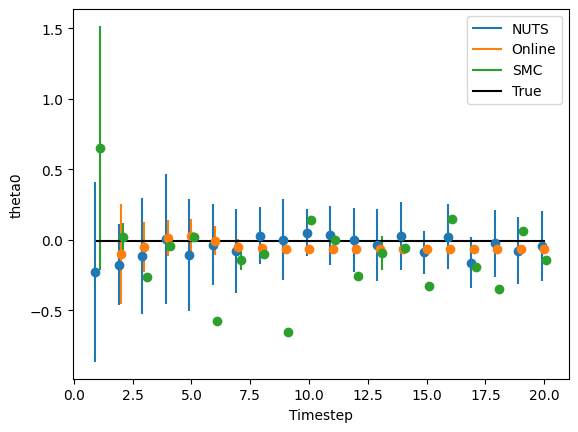

In [51]:
plotEstimates(chainDict,"theta0",prior_chain)

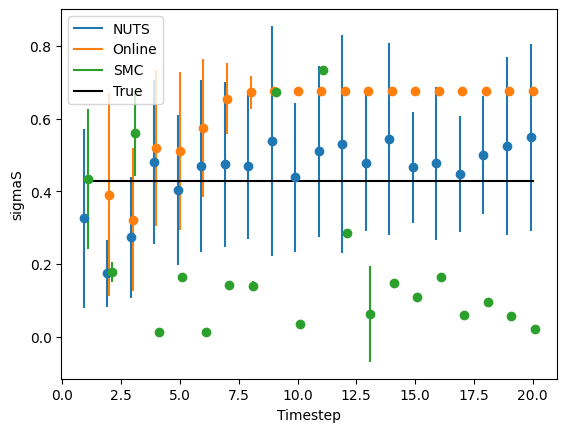

In [52]:
plotEstimates(chainDict,"sigmaS",prior_chain)

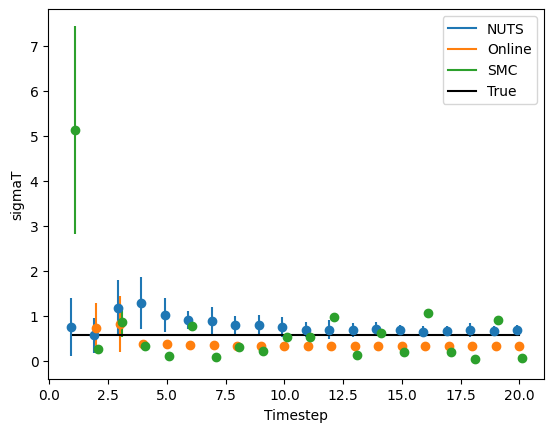

In [53]:
plotEstimates(chainDict,"sigmaT",prior_chain)

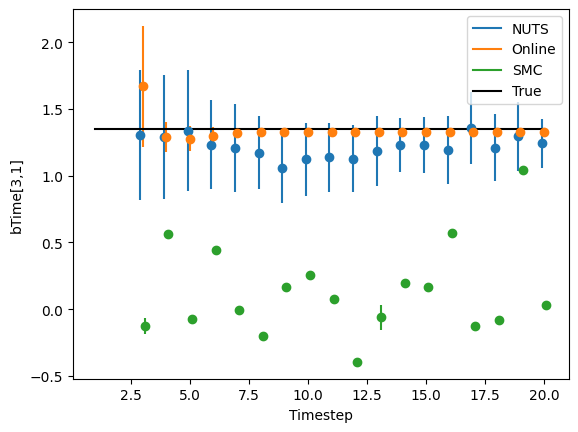

In [54]:
plotEstimates(chainDict,"bTime[3,1]",prior_chain)

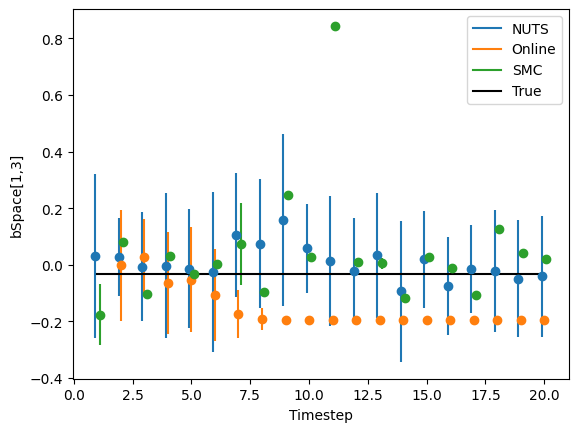

In [55]:
plotEstimates(chainDict,"bSpace[1,3]",prior_chain)

## Posterior predictive

In [56]:
#poster_predictive = tur.predict(m_missing_full,chain_NUTS_full)

### Write out

In [57]:
#run(`jupyter nbconvert --to html OnlineUpdate_GALM_Poisson.ipynb`)

In [58]:
#run(`jupyter nbconvert --to markdown OnlineUpdate_GALM_Poisson.ipynb`)